In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
# Read X_train.csv, X_test.csv, y_train.csv, y_test.csv
X_train = pd.read_csv('Data1/X_train.csv')
X_test = pd.read_csv('Data1/X_test.csv')
y_train = pd.read_csv('Data1/y_train.csv')
y_test = pd.read_csv('Data1/y_test.csv')

In [3]:
# check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((604, 33), (259, 33), (604, 1), (259, 1))

In [4]:
from sklearn.metrics import make_scorer, fbeta_score

f2_scorer = make_scorer(fbeta_score, beta=2) # we care recall more than precision

### Decision Tree Classifier

In [5]:
# define a optuna objective function for decision tree classifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def dt_objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 12),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 66
    }
    dt = DecisionTreeClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        dt.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, dt.predict(X_test_op))
        # score = f2_scorer(dt, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [6]:
def early_stopping_check(study, trial, early_stopping_rounds=20): # default is to stop study if there are 20 trials without improvement
    current_trial_number = trial.number
    best_trial_number = study.best_trial.number
    should_stop = (current_trial_number - best_trial_number) >= early_stopping_rounds
    if should_stop:
        study.stop()

In [7]:
# run the optimization
from functools import partial

study_dt = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='DecisionTree')
study_dt.optimize(dt_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 22:24:36,079] A new study created in memory with name: DecisionTree
[I 2024-03-02 22:24:36,094] Trial 0 finished with value: 0.6755250151880859 and parameters: {'max_depth': 10, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6755250151880859.
[I 2024-03-02 22:24:36,108] Trial 1 finished with value: 0.6705416810337749 and parameters: {'max_depth': 7, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6755250151880859.
[I 2024-03-02 22:24:36,126] Trial 2 finished with value: 0.6788089256686862 and parameters: {'max_depth': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 2 with value: 0.6788089256686862.
[I 2024-03-02 22:24:36,140] Trial 3 finished with value: 0.6837758402705942 and parameters: {'max_depth': 3, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 3 with value: 0.6837758402705942.
[I 2024-03-02 22:24:36,156] Trial 4 finished with value: 0.6755250151880859 and parameters: {'ma

In [8]:
# Best hyperparameters
print('Best hyperparameters:', study_dt.best_params)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 9, 'criterion': 'entropy'}


## Result

In [9]:
# evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

dt = DecisionTreeClassifier(**study_dt.best_params)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       122
           1       0.68      0.77      0.73       137

    accuracy                           0.69       259
   macro avg       0.69      0.69      0.69       259
weighted avg       0.69      0.69      0.69       259

[[ 73  49]
 [ 31 106]]


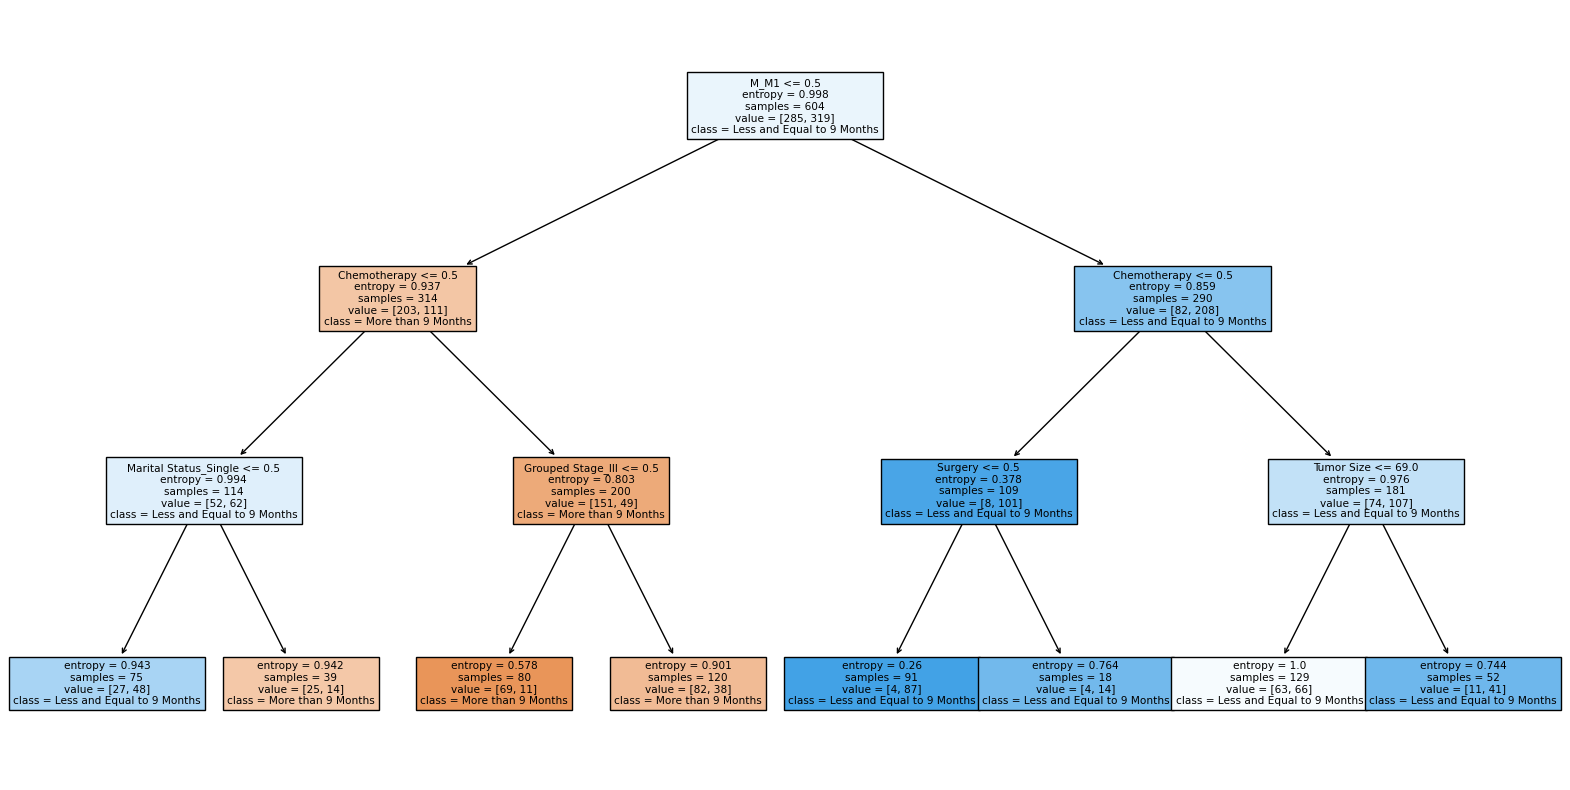

In [10]:
# visualize the tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['More than 9 Months','Less and Equal to 9 Months'])
plt.show()

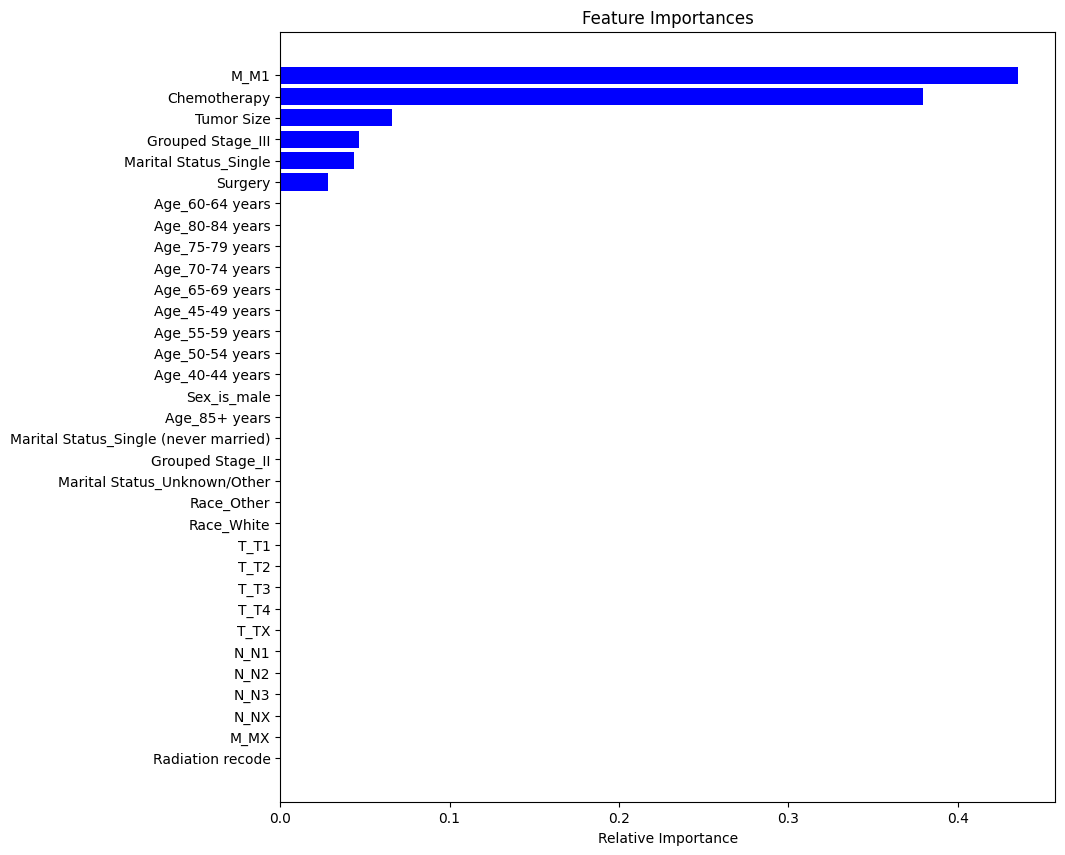

In [11]:
# plot feature importance
importances = dt.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Random Forest Classifier

In [12]:
from sklearn.preprocessing import StandardScaler
# Fit the scaler to the "Tumor Size" column in the training data
scaler = StandardScaler()
scaler.fit(X_train[["Tumor Size"]])
X_train["Tumor Size"] = scaler.transform(X_train[["Tumor Size"]])
X_test["Tumor Size"] = scaler.transform(X_test[["Tumor Size"]])

In [13]:
# define a optuna objective function for random forest classifier
from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),  
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # Limit depth to prevent overfitting
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 12),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),  
        'random_state': 66  
    }
    rf = RandomForestClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        rf.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, rf.predict(X_test_op))
        # score = f2_scorer(rf, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [14]:
# run the optimization
study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='RandomForest')
study_rf.optimize(rf_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 22:24:37,111] A new study created in memory with name: RandomForest
[I 2024-03-02 22:24:37,378] Trial 0 finished with value: 0.7003267490928197 and parameters: {'n_estimators': 117, 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 4, 'criterion': 'gini'}. Best is trial 0 with value: 0.7003267490928197.
[I 2024-03-02 22:24:37,663] Trial 1 finished with value: 0.70864325238494 and parameters: {'n_estimators': 136, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.70864325238494.
[I 2024-03-02 22:24:38,076] Trial 2 finished with value: 0.6821420948064957 and parameters: {'n_estimators': 175, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2, 'criterion': 'gini'}. Best is trial 1 with value: 0.70864325238494.
[I 2024-03-02 22:24:38,393] Trial 3 finished with value: 0.7135444887772359 and parameters: {'n_estimators': 165, 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 8, 'crite

In [15]:
# Best hyperparameters
print('Best hyperparameters:', study_rf.best_params)

Best hyperparameters: {'n_estimators': 292, 'max_depth': 9, 'min_samples_leaf': 12, 'min_samples_split': 7, 'criterion': 'entropy'}


## Result

In [16]:
# evaluate the model
rf = RandomForestClassifier(**study_rf.best_params)
rf.fit(X_train, y_train.squeeze())
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       122
           1       0.72      0.76      0.74       137

    accuracy                           0.72       259
   macro avg       0.72      0.72      0.72       259
weighted avg       0.72      0.72      0.72       259

[[ 82  40]
 [ 33 104]]


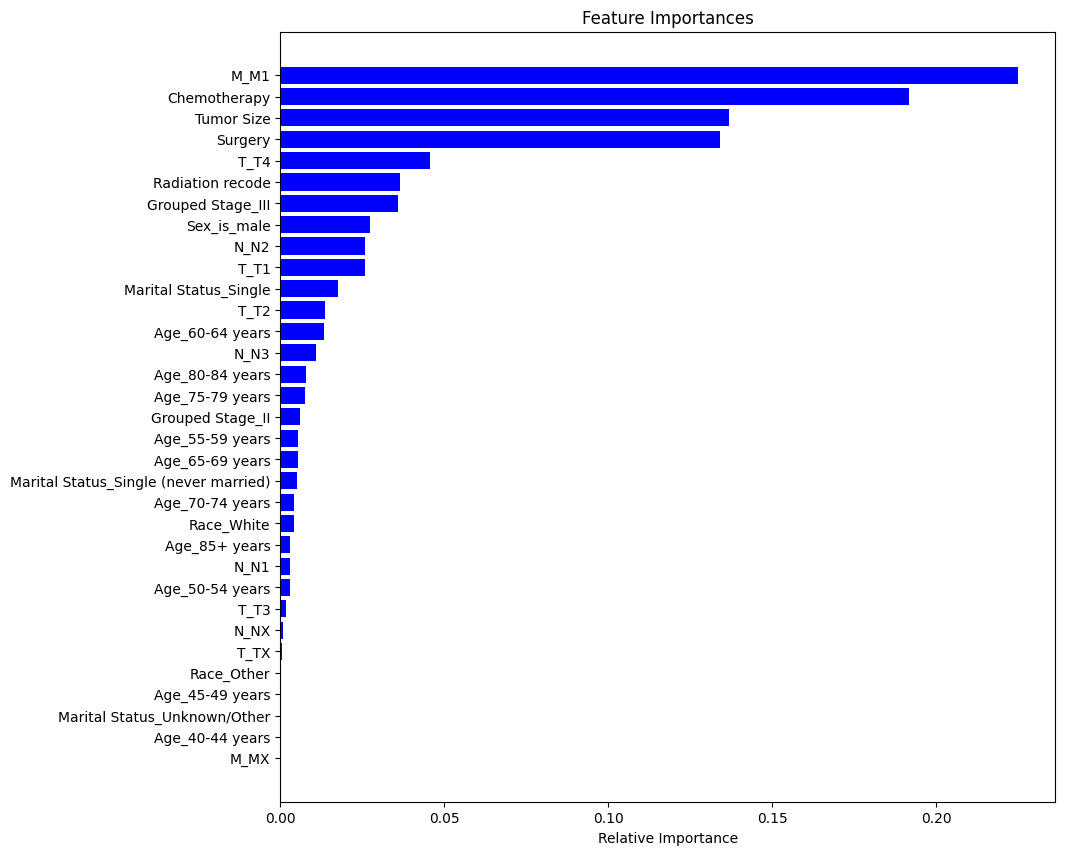

In [17]:
# plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## SVM

In [18]:
# define a optuna objective function for SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def svm_objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'random_state': 66
    }
    svm = SVC(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        svm.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, svm.predict(X_test_op))
        # score = f2_scorer(svm, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [19]:
# run the optimization
study_svm = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='SVM')
study_svm.optimize(svm_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 22:24:54,481] A new study created in memory with name: SVM
[I 2024-03-02 22:24:54,513] Trial 0 finished with value: 0.6953762540433147 and parameters: {'C': 1.9068146886379216, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}. Best is trial 0 with value: 0.6953762540433147.
[I 2024-03-02 22:24:54,537] Trial 1 finished with value: 0.6970017897312119 and parameters: {'C': 0.020241348147874365, 'kernel': 'linear', 'degree': 2, 'gamma': 'auto'}. Best is trial 1 with value: 0.6970017897312119.
[I 2024-03-02 22:24:54,561] Trial 2 finished with value: 0.6804755102375909 and parameters: {'C': 0.06874527826739463, 'kernel': 'linear', 'degree': 4, 'gamma': 'scale'}. Best is trial 1 with value: 0.6970017897312119.
[I 2024-03-02 22:24:55,614] Trial 3 finished with value: 0.6739076892763903 and parameters: {'C': 188.26312521250028, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto'}. Best is trial 1 with value: 0.6970017897312119.
[I 2024-03-02 22:24:55,637] Trial 4 finished with value: 

In [20]:
# Best hyperparameters
print('Best hyperparameters:', study_svm.best_params)

Best hyperparameters: {'C': 0.011758765886780757, 'kernel': 'linear', 'degree': 3, 'gamma': 'scale'}


## Result

In [21]:
# evaluate the model
svm = SVC(**study_svm.best_params)
svm.fit(X_train, y_train.squeeze())
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.72      0.66      0.69       122
           1       0.72      0.77      0.74       137

    accuracy                           0.72       259
   macro avg       0.72      0.72      0.72       259
weighted avg       0.72      0.72      0.72       259

[[ 81  41]
 [ 32 105]]


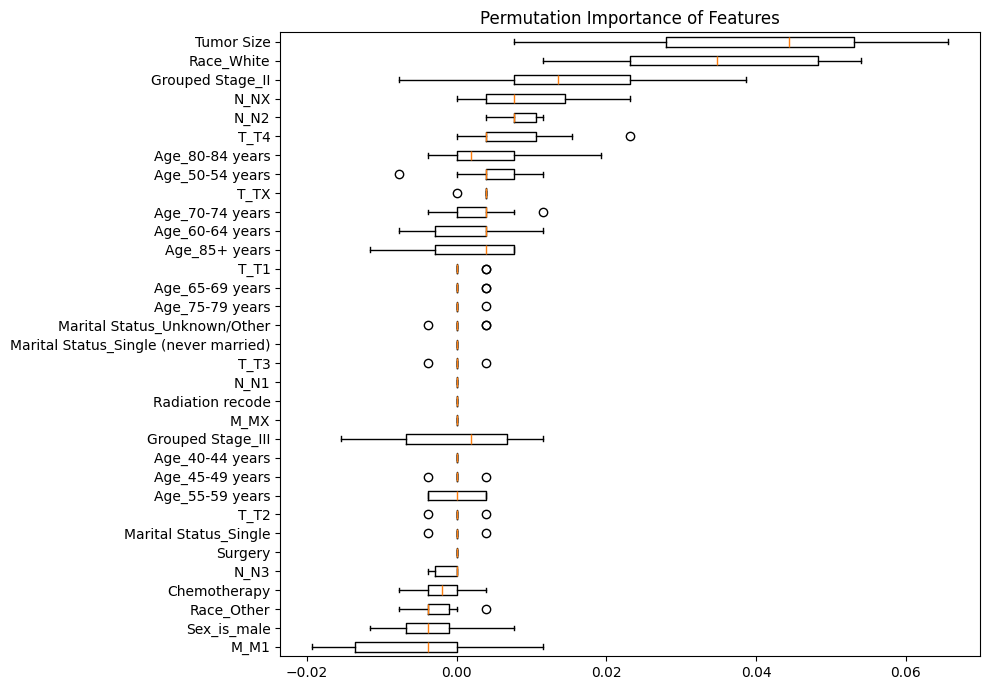

In [22]:
# plot feature importance
from sklearn.inspection import permutation_importance
result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
stds = result.importances_std

feature_names = [X_train.columns[i] for i in result.importances_mean.argsort()]

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

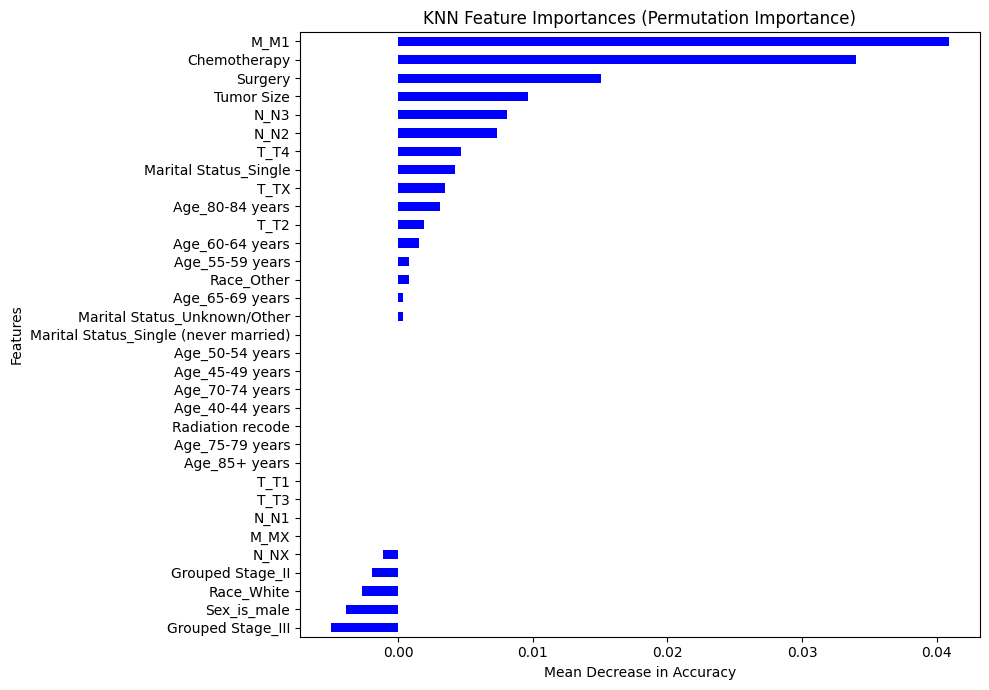

In [23]:
result = permutation_importance(svm, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Convert importances into a pandas Series for easier plotting, with feature names as the index
feature_importances_knn = pd.Series(data=result.importances_mean, index=X_train.columns)

# Sorting the importances for visualization
importances_sorted_knn = feature_importances_knn.sort_values()

# Plotting KNN feature importances
plt.figure(figsize=(10, 7))
importances_sorted_knn.plot(kind='barh', color='blue')
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## KNN

In [24]:
# define a optuna objective function for KNN
from sklearn.neighbors import KNeighborsClassifier

def knn_objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'p': trial.suggest_int('p', 1, 2),
    }
    knn = KNeighborsClassifier(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        knn.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, knn.predict(X_test_op))
        score = f2_scorer(knn, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [25]:
# run the optimization
study_knn = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='KNN')
study_knn.optimize(knn_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 22:25:00,251] A new study created in memory with name: KNN
[I 2024-03-02 22:25:00,290] Trial 0 finished with value: 0.7086447795971713 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 0 with value: 0.7086447795971713.
[I 2024-03-02 22:25:00,331] Trial 1 finished with value: 0.7020182512678282 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 0 with value: 0.7086447795971713.
[I 2024-03-02 22:25:00,592] Trial 2 finished with value: 0.6923024394343708 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'p': 2}. Best is trial 0 with value: 0.7086447795971713.
[I 2024-03-02 22:25:00,673] Trial 3 finished with value: 0.7020727917785649 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}. Best is trial 0 with value: 0.7086447795971713.
[I 2024-03-02 22:25:00,763] Trial 4 finished with value: 0.70999238563

In [26]:
# Best hyperparameters
print('Best hyperparameters:', study_knn.best_params)


Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'auto', 'p': 2}


## Result

In [27]:
# evaluate the model
knn = KNeighborsClassifier(**study_knn.best_params)
knn.fit(X_train, y_train.squeeze())
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       122
           1       0.71      0.78      0.74       137

    accuracy                           0.71       259
   macro avg       0.72      0.71      0.71       259
weighted avg       0.72      0.71      0.71       259

[[ 78  44]
 [ 30 107]]


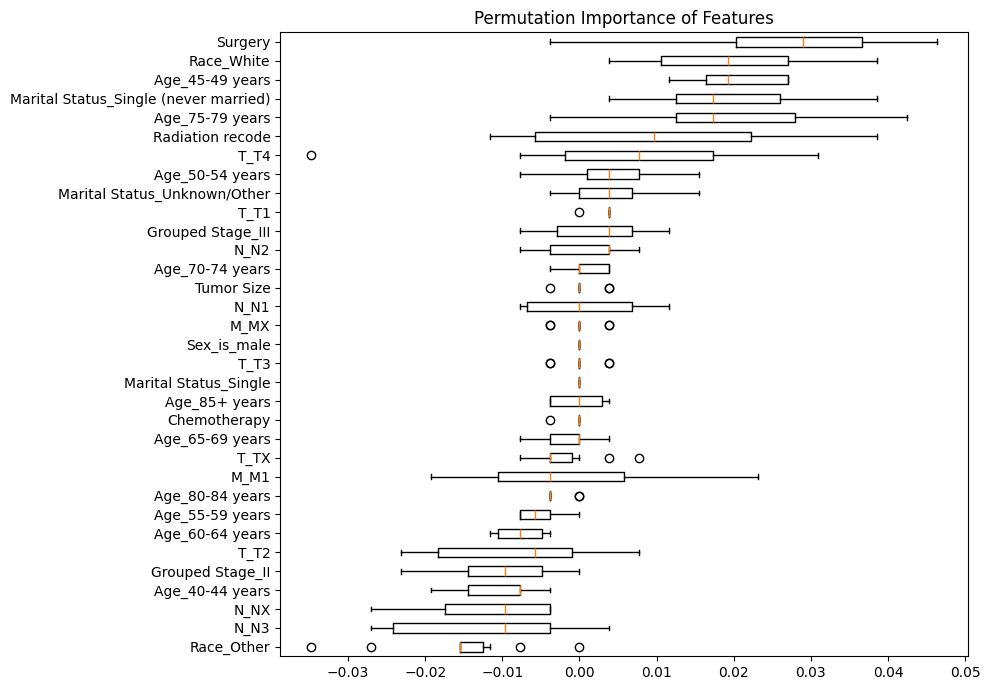

In [28]:
# plot feature importance for KNN
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Get the importances and their standard deviations
importances = result.importances_mean
stds = result.importances_std

feature_names = [X_train.columns[i] for i in result.importances_mean.argsort()]

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 7))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



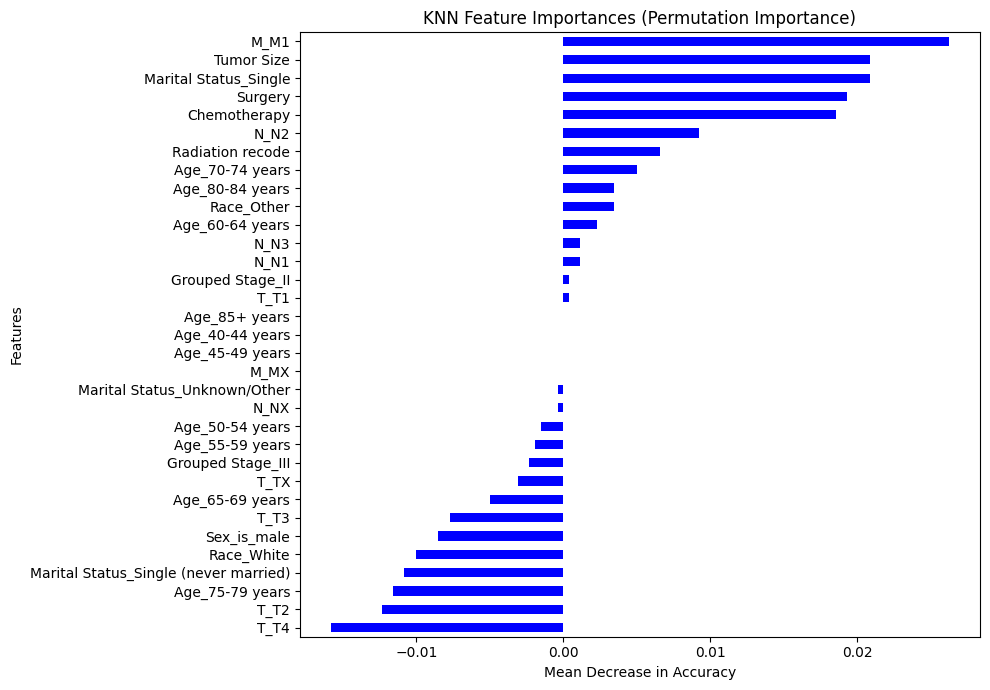

In [29]:
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=66, n_jobs=-1)

# Convert importances into a pandas Series for easier plotting, with feature names as the index
feature_importances_knn = pd.Series(data=result.importances_mean, index=X_train.columns)

# Sorting the importances for visualization
importances_sorted_knn = feature_importances_knn.sort_values()

# Plotting KNN feature importances
plt.figure(figsize=(10, 7))
importances_sorted_knn.plot(kind='barh', color='blue')
plt.title('KNN Feature Importances (Permutation Importance)')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Logistic Regression

In [30]:
# define a optuna objective function for logistic regression
from sklearn.linear_model import LogisticRegression

def lr_objective(trial):
    param = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'random_state': 66
    }
    lr = LogisticRegression(**param)

    # Custom cross-validation with pruning
    kf = KFold(n_splits=3)
    scores = []
    for train_index, test_index in kf.split(X_train): # split data to validate the model
        X_train_op, X_test_op = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_op, y_test_op = y_train.iloc[train_index], y_train.iloc[test_index]
        y_train_op = y_train_op.squeeze()
        lr.fit(X_train_op, y_train_op)
        score = accuracy_score(y_test_op, lr.predict(X_test_op))
        # score = f2_scorer(lr, X_test_op, y_test_op)  
        scores.append(score)
        # Report intermediate score and check for pruning
        trial.report(np.mean(scores), len(scores))
        if trial.should_prune():
            raise optuna.TrialPruned()
    return np.mean(scores)

In [31]:
# run the optimization
study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(),
                                study_name='LogisticRegression')
study_lr.optimize(lr_objective, n_trials=100, callbacks=[partial(early_stopping_check, early_stopping_rounds=20)])

[I 2024-03-02 22:25:03,403] A new study created in memory with name: LogisticRegression
[I 2024-03-02 22:25:03,416] Trial 0 finished with value: 0.6870843800797989 and parameters: {'C': 0.06011757571780677, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.6870843800797989.
[I 2024-03-02 22:25:03,429] Trial 1 finished with value: 0.6904011296652053 and parameters: {'C': 0.0062466838629121986, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.6904011296652053.
[I 2024-03-02 22:25:03,449] Trial 2 finished with value: 0.6969935799550103 and parameters: {'C': 0.04907089479941912, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.6969935799550103.
[I 2024-03-02 22:25:03,463] Trial 3 finished with value: 0.6771669704283861 and parameters: {'C': 4.144180680630364, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.6969935799550103.
[I 2024-03-02 22:25:03,475] Trial 4 finished with value: 0.6788335549972908 and param

In [32]:
# Best hyperparameters
print('Best hyperparameters:', study_lr.best_params)

Best hyperparameters: {'C': 0.4287795056305377, 'penalty': 'l1', 'solver': 'liblinear'}


## Result

In [33]:
# evaluate the model
lr = LogisticRegression(**study_lr.best_params)
lr.fit(X_train, y_train.squeeze())
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       122
           1       0.75      0.74      0.75       137

    accuracy                           0.73       259
   macro avg       0.73      0.73      0.73       259
weighted avg       0.73      0.73      0.73       259

[[ 88  34]
 [ 35 102]]


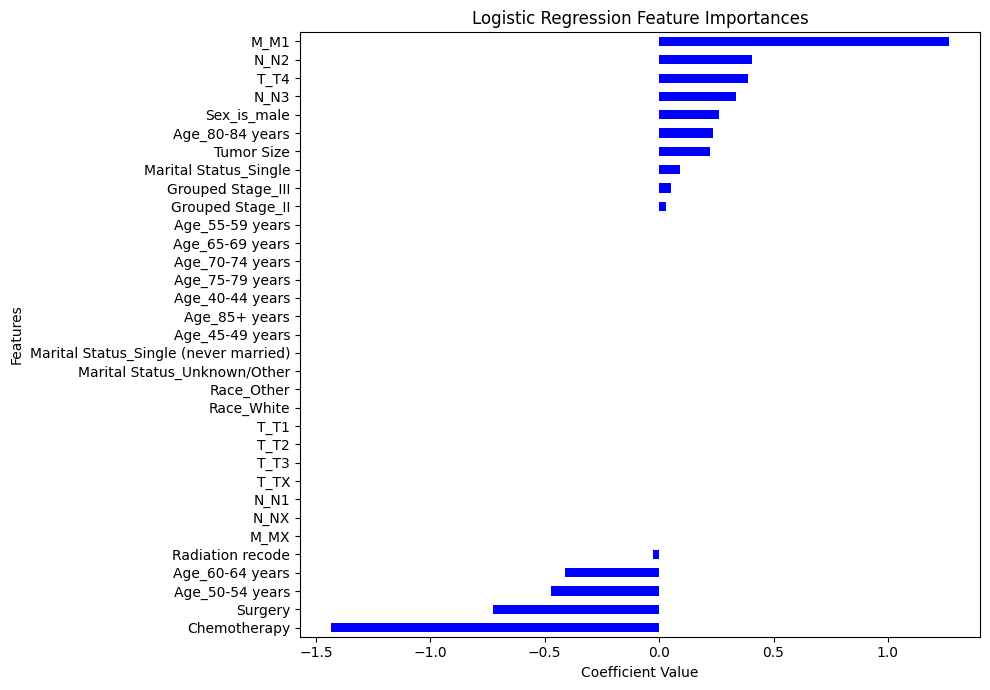

In [34]:
# Plot the feature importances
feature_importances_lr = pd.Series(data=lr.coef_[0], index=X_train.columns)

# Sorting the coefficients for visualization
importances_sorted_lr = feature_importances_lr.sort_values()

# Plotting logistic regression feature importances
plt.figure(figsize=(10, 7))
importances_sorted_lr.plot(kind='barh', color='blue')
plt.title('Logistic Regression Feature Importances')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## LightGBM

In [35]:
from optuna.integration.lightgbm import LightGBMTunerCV as lgbtcv
import lightgbm as lgb
from lightgbm import early_stopping
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [36]:
# Parameters for LightGBM
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    # "metric": "lgb_f2_eval",  # Use custom metric
    "boosting_type": "gbdt",
    "verbosity": -1,
}

# Create LightGBM dataset
dtrain= lgb.Dataset(X_train, label=y_train)

study_auto_lgb = optuna.create_study(direction='minimize', study_name='LightGBM Tuner CV')
# Perform cross-validation
auto_lgb_tuner = lgbtcv(
    params=params, 
    train_set=dtrain,  
    num_boost_round=300,  # Number of boosting iterations
    nfold=3,  
    stratified=True,  # Perform stratified sampling
    seed=66,  # Fix random seed for reproducibility of cv
    optuna_seed=66,  # Fix random seed for reproducibility of optuna trials
    shuffle=True,  # Shuffle data before creating folds
    callbacks=[early_stopping(20)],
    study=study_auto_lgb
)

In [37]:
auto_lgb_tuner.run()

feature_fraction, val_score: 0.567568:  14%|#4        | 1/7 [00:00<00:00,  8.00it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	cv_agg's valid binary_logloss: 0.579447 + 0.0265295


feature_fraction, val_score: 0.567568:  57%|#####7    | 4/7 [00:00<00:00, 11.21it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567722 + 0.02856
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	cv_agg's valid binary_logloss: 0.575424 + 0.0238788
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	cv_agg's valid binary_logloss: 0.572375 + 0.0244274


feature_fraction, val_score: 0.567568: 100%|##########| 7/7 [00:00<00:00, 13.63it/s]


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	cv_agg's valid binary_logloss: 0.579139 + 0.0195442
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	cv_agg's valid binary_logloss: 0.571712 + 0.0243289


num_leaves, val_score: 0.567568:   5%|5         | 1/20 [00:00<00:01, 13.50it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824


num_leaves, val_score: 0.567568:  10%|#         | 2/20 [00:00<00:01, 11.64it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: 0.567568:  20%|##        | 4/20 [00:00<00:01,  8.53it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: 0.567333:  30%|###       | 6/20 [00:00<00:01,  8.07it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567333 + 0.0266216
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: 0.560217:  40%|####      | 8/20 [00:00<00:01,  8.95it/s]

Early stopping, best iteration is:
[33]	cv_agg's valid binary_logloss: 0.560217 + 0.0251409
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.565784 + 0.0249196
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824


num_leaves, val_score: 0.560217:  55%|#####5    | 11/20 [00:01<00:00, 10.41it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	cv_agg's valid binary_logloss: 0.561894 + 0.0231463
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: 0.560217:  70%|#######   | 14/20 [00:01<00:00, 10.98it/s]

Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824


num_leaves, val_score: 0.559201:  85%|########5 | 17/20 [00:01<00:00, 12.62it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	cv_agg's valid binary_logloss: 0.559201 + 0.0257884
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	cv_agg's valid binary_logloss: 0.559201 + 0.0257884
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	cv_agg's valid binary_logloss: 0.559201 + 0.0257884
Training until validation scores don't improve for 20 rounds


num_leaves, val_score: 0.559201: 100%|##########| 20/20 [00:01<00:00, 11.01it/s]


Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	cv_agg's valid binary_logloss: 0.567568 + 0.0276824


bagging, val_score: 0.559201:  20%|##        | 2/10 [00:00<00:00, 15.12it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	cv_agg's valid binary_logloss: 0.566856 + 0.0223885
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.559511 + 0.0219585
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	cv_agg's valid binary_logloss: 0.562078 + 0.0245537


bagging, val_score: 0.558717:  60%|######    | 6/10 [00:00<00:00, 15.79it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	cv_agg's valid binary_logloss: 0.568174 + 0.0198207
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.559501 + 0.0219396
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	cv_agg's valid binary_logloss: 0.558717 + 0.0269809


bagging, val_score: 0.558717:  80%|########  | 8/10 [00:00<00:00, 13.21it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	cv_agg's valid binary_logloss: 0.559098 + 0.0204123
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.560453 + 0.0204892
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557617 + 0.0221034


bagging, val_score: 0.557617: 100%|##########| 10/10 [00:00<00:00, 14.39it/s]


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.558969 + 0.0212649


feature_fraction_stage2, val_score: 0.557617:  33%|###3      | 1/3 [00:00<00:00, 12.16it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	cv_agg's valid binary_logloss: 0.558189 + 0.0207931
Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: 0.557617:  67%|######6   | 2/3 [00:00<00:00, 12.66it/s]

Early stopping, best iteration is:
[46]	cv_agg's valid binary_logloss: 0.561975 + 0.0192017
Training until validation scores don't improve for 20 rounds


feature_fraction_stage2, val_score: 0.557617: 100%|##########| 3/3 [00:00<00:00, 12.74it/s]


Early stopping, best iteration is:
[52]	cv_agg's valid binary_logloss: 0.56077 + 0.0212162


regularization_factors, val_score: 0.557579:   5%|5         | 1/20 [00:00<00:01, 12.48it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557579 + 0.0215024
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: 0.557451:  10%|#         | 2/20 [00:00<00:01, 14.22it/s]

Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.558538 + 0.0220873
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557451 + 0.0205634


regularization_factors, val_score: 0.557451:  15%|#5        | 3/20 [00:00<00:01, 14.22it/s]

Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: 0.557450:  20%|##        | 4/20 [00:00<00:01, 14.62it/s]

Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.55745 + 0.0205816
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: 0.557450:  25%|##5       | 5/20 [00:00<00:01, 14.62it/s]

Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.558116 + 0.0209228
Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: 0.557450:  30%|###       | 6/20 [00:00<00:01, 13.41it/s]

Early stopping, best iteration is:
[57]	cv_agg's valid binary_logloss: 0.557636 + 0.0192427


regularization_factors, val_score: 0.557450:  35%|###5      | 7/20 [00:00<00:00, 13.41it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	cv_agg's valid binary_logloss: 0.558407 + 0.0214621
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.558118 + 0.0208834


regularization_factors, val_score: 0.557450:  40%|####      | 8/20 [00:00<00:00, 14.17it/s]

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557616 + 0.022098


regularization_factors, val_score: 0.557450:  45%|####5     | 9/20 [00:00<00:00, 14.17it/s]

Training until validation scores don't improve for 20 rounds

regularization_factors, val_score: 0.557450:  50%|#####     | 10/20 [00:00<00:00, 15.35it/s]


Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557617 + 0.022101
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557617 + 0.0221019


regularization_factors, val_score: 0.557450:  55%|#####5    | 11/20 [00:00<00:00, 15.35it/s]

Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: 0.556829:  65%|######5   | 13/20 [00:01<00:00, 12.99it/s]

Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557617 + 0.0221024
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.557617 + 0.0221012
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556829 + 0.0212588


regularization_factors, val_score: 0.556829:  70%|#######   | 14/20 [00:01<00:00, 13.85it/s]

Training until validation scores don't improve for 20 rounds


regularization_factors, val_score: 0.556822:  80%|########  | 16/20 [00:01<00:00, 13.13it/s]

Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556827 + 0.0212384
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556824 + 0.0212124
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556822 + 0.0211923


regularization_factors, val_score: 0.556822:  85%|########5 | 17/20 [00:01<00:00, 13.13it/s]

Training until validation scores don't improve for 20 rounds

regularization_factors, val_score: 0.556822: 100%|##########| 20/20 [00:01<00:00, 13.95it/s]



Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556826 + 0.0212338
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556826 + 0.0212309
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	cv_agg's valid binary_logloss: 0.556826 + 0.0212257


min_child_samples, val_score: 0.556822:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: 0.555948:  60%|######    | 3/5 [00:00<00:00, 18.80it/s]

Early stopping, best iteration is:
[52]	cv_agg's valid binary_logloss: 0.559606 + 0.0216456
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	cv_agg's valid binary_logloss: 0.56308 + 0.0196917
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[128]	cv_agg's valid binary_logloss: 0.555948 + 0.0226895
Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: 0.555948:  80%|########  | 4/5 [00:00<00:00, 12.03it/s]

Early stopping, best iteration is:
[48]	cv_agg's valid binary_logloss: 0.562086 + 0.0177676
Training until validation scores don't improve for 20 rounds


min_child_samples, val_score: 0.555948: 100%|##########| 5/5 [00:00<00:00, 11.85it/s]

Early stopping, best iteration is:
[78]	cv_agg's valid binary_logloss: 0.55685 + 0.0253641


In [61]:
# Best hyperparameters
auto_params = auto_lgb_tuner.best_params
auto_best_lgb= lgb.LGBMClassifier(**auto_params, random_state=66)
auto_best_lgb.fit(X_train, y_train)
print('Best hyperparameters:', auto_params)

Best hyperparameters: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'feature_pre_filter': False, 'lambda_l1': 5.389055616959793e-07, 'lambda_l2': 0.05156395819023616, 'num_leaves': 3, 'feature_fraction': 0.4, 'bagging_fraction': 0.8420562122268799, 'bagging_freq': 4, 'min_child_samples': 100}


## Result

In [39]:
# evaluate the model and print the classification report
# predict the test set
y_pred = auto_best_lgb.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       122
           1       0.70      0.75      0.72       137

    accuracy                           0.69       259
   macro avg       0.69      0.69      0.69       259
weighted avg       0.69      0.69      0.69       259

[[ 77  45]
 [ 34 103]]


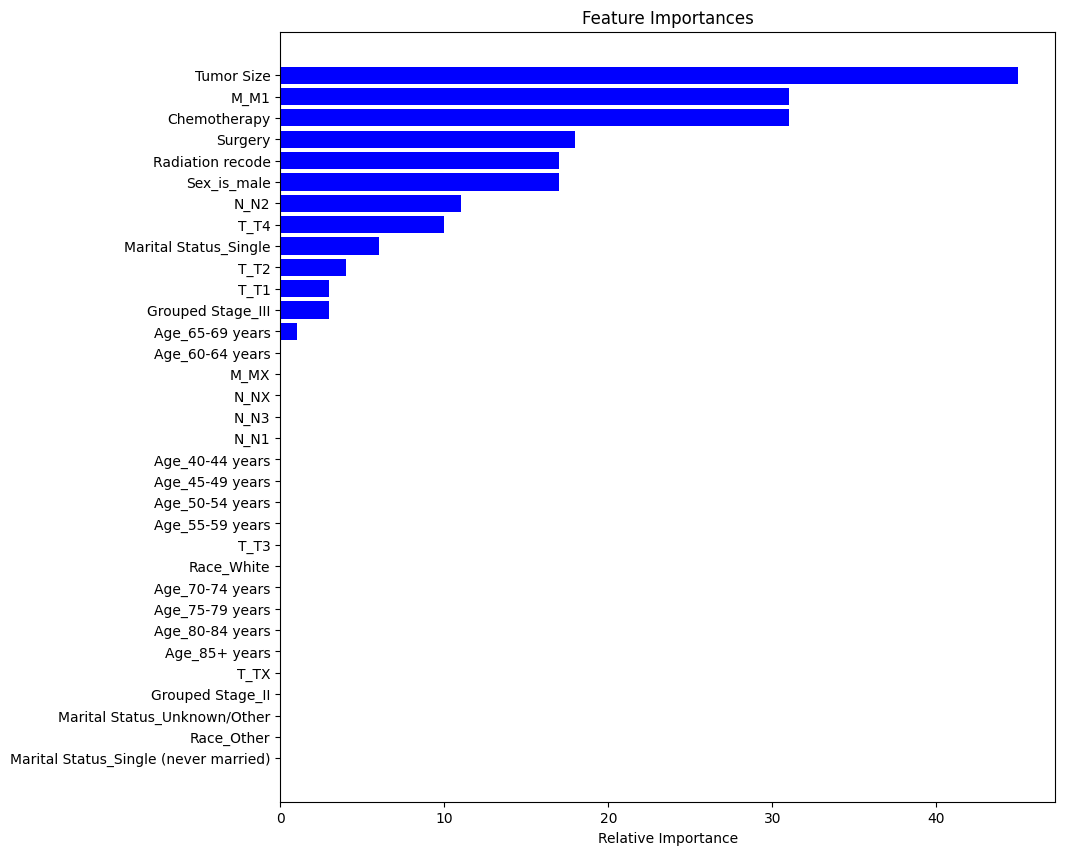

In [40]:
# plot feature importance
importances = auto_best_lgb.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Neural Network

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

In [64]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)  # Hidden layer with 16 neurons
        self.dropout = nn.Dropout(0.5)          # Dropout layer for regularization
        self.layer2 = nn.Linear(16, 8)          # Hidden layer with 8 neurons
        self.layer3 = nn.Linear(8, 1)           # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Activation function for hidden layer
        x = self.dropout(x)             # Apply dropout
        x = torch.relu(self.layer2(x))  # Activation function for hidden layer
        x = torch.sigmoid(self.layer3(x))  # Sigmoid activation function for output layer
        return x


In [65]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape y to be 2D
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)



In [66]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
from torch.optim import lr_scheduler
input_size = X_train.shape[1]
model_mlp = SimpleNN(input_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
# Optimizer with a starting learning rate
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5, verbose=True)
num_epochs = 100
patience = 10

In [68]:
device = 'cpu'

In [69]:
import copy

best_loss = float('inf')
best_model_wts = copy.deepcopy(model_mlp.state_dict())  # To store the best model weights
counter_early_stopping = 0  # Counter for early stopping
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    model_mlp.train()  # Set model to training mode
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        # Forward pass
        predictions = model_mlp(data)
        # Calculate loss
        loss = criterion(predictions, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss over the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Evaluate the model
    model_mlp.eval()  # Set model to evaluate mode
    total_test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            predictions = model_mlp(data)
            loss = criterion(predictions, target)
            total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_history.append(avg_test_loss)

    # Print training and test loss
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    # Check for early stopping
    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_wts = copy.deepcopy(model_mlp.state_dict())
        print(f'Epoch {epoch+1} has the best Test Loss: {avg_test_loss}')
        counter_early_stopping = 0
        # Save the best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_mlp.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model_checkpoint.pth')
    else:
        counter_early_stopping += 1
        if counter_early_stopping >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    # Update the learning rate
    scheduler.step(avg_test_loss)

# Load the best model weights
model_mlp.load_state_dict(best_model_wts)


Epoch 1/100, Training Loss: 0.7046796679496765, Test Loss: 0.6978063583374023
Epoch 1 has the best Test Loss: 0.6978063583374023
Epoch 2/100, Training Loss: 0.7001523626478094, Test Loss: 0.6928945846027799
Epoch 2 has the best Test Loss: 0.6928945846027799
Epoch 3/100, Training Loss: 0.6914885546031752, Test Loss: 0.687719636493259
Epoch 3 has the best Test Loss: 0.687719636493259
Epoch 4/100, Training Loss: 0.6865960704652887, Test Loss: 0.6820977528889974
Epoch 4 has the best Test Loss: 0.6820977528889974
Epoch 5/100, Training Loss: 0.6834453062007302, Test Loss: 0.6763290564219157
Epoch 5 has the best Test Loss: 0.6763290564219157
Epoch 6/100, Training Loss: 0.6739603218279386, Test Loss: 0.6695864200592041
Epoch 6 has the best Test Loss: 0.6695864200592041
Epoch 7/100, Training Loss: 0.6683819199863233, Test Loss: 0.6616904271973504
Epoch 7 has the best Test Loss: 0.6616904271973504
Epoch 8/100, Training Loss: 0.6618295123702601, Test Loss: 0.6536896096335517
Epoch 8 has the best 

<All keys matched successfully>

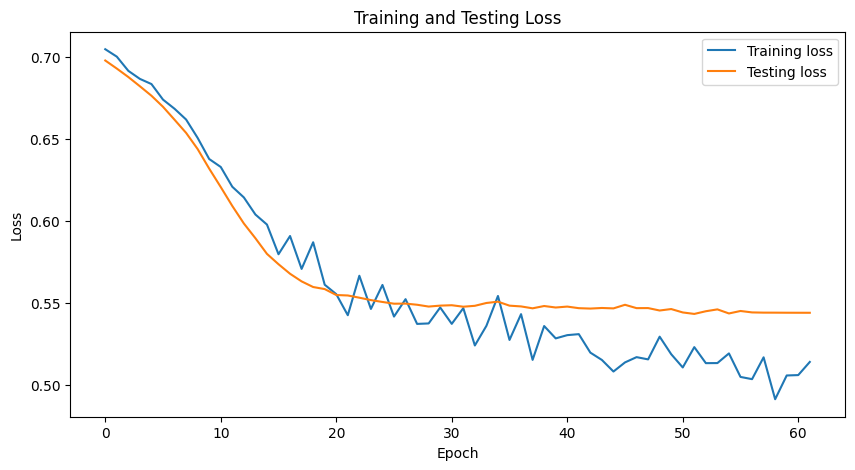

In [70]:
# Plot the training and test loss
plt.plot(train_loss_history, label='Training loss')
plt.plot(test_loss_history, label='Testing loss')
plt.legend()
# fix the size of the plot
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [72]:
model_mlp.eval()

SimpleNN(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)

## Result

In [74]:
# Evaluate the model
with torch.no_grad():
    y_pred = model_mlp(X_test_tensor)
    y_pred = (y_pred >= 0.5).float()  # Convert to binary predictions

# Print the classification report
print(classification_report(y_test_tensor, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test_tensor, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.76      0.73       122
         1.0       0.77      0.70      0.73       137

    accuracy                           0.73       259
   macro avg       0.73      0.73      0.73       259
weighted avg       0.73      0.73      0.73       259

[[93 29]
 [41 96]]


## Conclusion

| Model               | Accuracy | Precision for Class 1 | Recall for Class 1 | F1-score for Class 1 |
|--------------------|---------|----------------------|--------------------|-----------|
| Decision Tree       | 0.69    | 0.68                  | 0.77                | 0.73      |
| RandomForest        | 0.71    | 0.72                  | 0.75                | 0.73      |
| SVM                 | 0.73    | 0.72                  | 0.81                | 0.76      |
| KNN                 | 0.69    | 0.69                  | 0.76                | 0.72      |
| LogisticRegression | 0.73    | 0.75                  | 0.74                | 0.74      |
| LightGBM            | 0.69    | 0.70                  | 0.75                | 0.72      |
| MLP                 | 0.73    | 0.76                  | 0.72                | 0.74      |


## lift chart for the best model - random forest

In [51]:
import kds

In [53]:
!pip install scikitplot

ERROR: Could not find a version that satisfies the requirement scikitplot (from versions: none)
ERROR: No matching distribution found for scikitplot


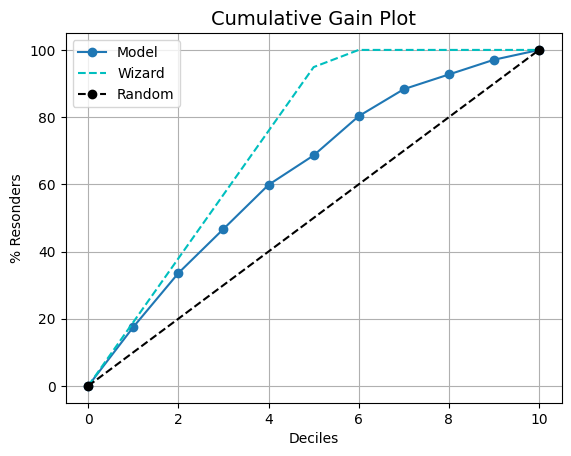

In [56]:
svm = SVC(**study_svm.best_params, probability=True)
svm.fit(X_train, y_train.squeeze())
y_prob = svm.predict_proba(X_test)
kds.metrics.plot_cumulative_gain(y_test.squeeze(), y_prob[:,1])
plt.show()

## ROC curve 

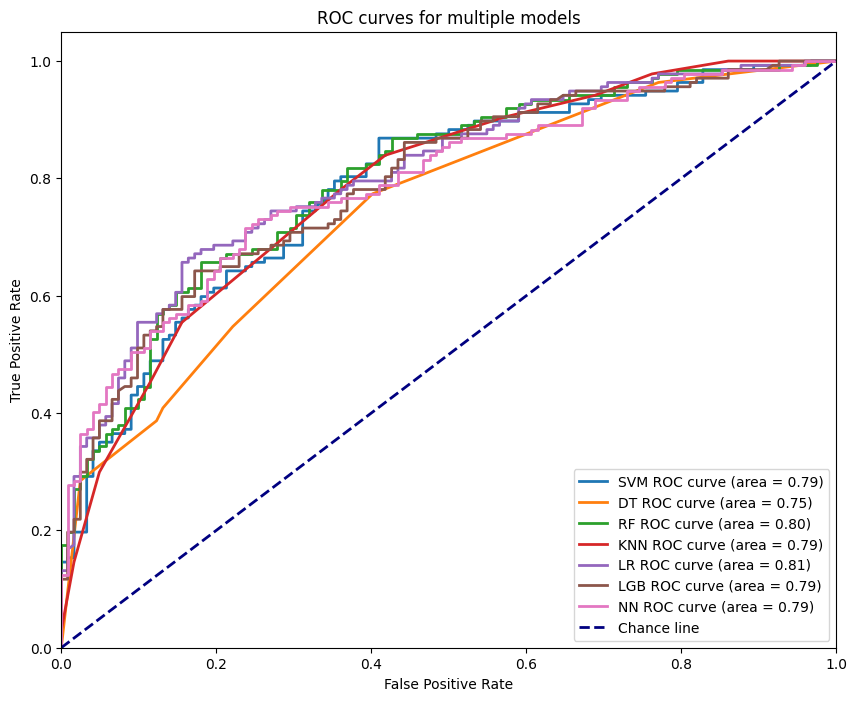

In [78]:
import matplotlib.pyplot as plt


models = {
    'SVM': SVC(**study_svm.best_params, probability=True).fit(X_train, y_train.squeeze()),
    'DT': DecisionTreeClassifier(**study_dt.best_params).fit(X_train, y_train),
    'RF': RandomForestClassifier(**study_rf.best_params).fit(X_train, y_train),
    'KNN': KNeighborsClassifier(**study_knn.best_params).fit(X_train, y_train),
    'LR': LogisticRegression(**study_lr.best_params).fit(X_train, y_train),
    'LGB': lgb.LGBMClassifier(**auto_params, random_state=66).fit(X_train, y_train)
}

# Initialize plot
plt.figure(figsize=(10, 8))
lw = 2  # Line width

# Plot ROC for each model
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:  # For models like LightGBM that use a different method
        y_prob = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, label=f'{name} ROC curve (area = {roc_auc:.2f})')

# Neural Network
model_mlp.eval()  
with torch.no_grad():
    y_pred_nn = model_mlp(X_test_tensor).numpy()
fpr, tpr, _ = roc_curve(y_test, y_pred_nn)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, label=f'NN ROC curve (area = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Chance line')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple models')
plt.legend(loc="lower right")
plt.show()


## Save all the models

In [134]:
# save all the models
import joblib
joblib.dump(study_dt, 'Models/study_dt.pkl')
joblib.dump(study_rf, 'Models/study_rf.pkl')
joblib.dump(study_svm, 'Models/study_svm.pkl')
joblib.dump(study_knn, 'Models/study_knn.pkl')
joblib.dump(study_lr, 'Models/study_lr.pkl')
joblib.dump(auto_best_lgb, 'Models/auto_best_lgb.pkl')
torch.save(model.state_dict(), 'Models/model_nn_state_dict.pth')
